 ### Loading Data

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import time
import datetime

In [2]:
# reading csv files
data =  pd.read_csv('spambase.data', sep=",", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.08,0.17,0.17,0.0,0.80,0.08,0.00,0.26,0.00,0.00,...,0.023,0.046,0.0,0.000,0.023,0.0,2.658,57,436,0
1,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.0,1.769,8,23,0
2,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.16,0.00,...,0.000,0.000,0.0,0.000,0.000,0.0,1.200,3,12,0
3,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,2.38,...,0.000,0.000,0.0,0.442,0.000,0.0,2.125,10,17,0
4,0.00,0.00,0.32,0.0,0.65,0.65,0.32,0.32,0.00,0.00,...,0.000,0.106,0.0,0.000,0.159,0.0,1.494,10,139,1


In [3]:
data.shape

(4601, 58)

In [4]:
X = data.iloc[:,0:57]
y = data.iloc[:,-1]
y = y.replace(0,-1)

In [5]:
train_X,test_X,train_y, test_y = train_test_split(X,y,test_size =0.25,random_state=42)

### Adaboost

In [6]:
import math

In [7]:
class BoostingStump():
    def __init(self):
        self.polarity = 1
        self.axis=None
        self.threshold = None
        self.error = None
    def fit(self,X,y,D_i):
        min_error = math.inf
        for i in range(X.shape[1]):
            feature_values = np.array(X.iloc[:,0])
            unique_thresholds = np.unique(feature_values)
            for threshold in unique_thresholds:
                polarity=1
                pred=np.ones(np.shape(y))
                pred[X.to_numpy()[:,i] <threshold]=-1
                #error = sum(D_i[y!=pred])
                error = (sum(D_i * (np.not_equal(np.array(y),pred)).astype(int))) / sum(D_i)
                if error > 0.5:
                    error = 1- error
                    polarity = -1
                if error<min_error:
                    self.polarity = polarity
                    self.threshold = threshold
                    self.axis = i
                    min_error = error
                    self.error = min_error
    def predict(self,X):
        pred=np.ones(np.shape(X)[0])
        if self.polarity==1:
            pred[X.to_numpy()[:,self.axis] <self.threshold]=-1
        else:
            pred[X.to_numpy()[:,self.axis] >self.threshold]=-1
        return pred


In [32]:
class AdaBoost:
    def __init__(self, n=100):
        self.weak_learners=[]
        self.train_errors=[]
        self.test_errors=[]
        self.rounds=n
        self.alphas=[]
    def __update_weights__(self,D_i,alpha,y,y_pred,Z):
        ''' Update weights 
        D_i: weights from last round
        y: label
        y_pred: predicted output
        Z: normalization factor
        '''
        return  D_i * np.exp( - alpha*y*y_pred) / Z
    def __compute_alpha__(self,e):
        ''' Compute alpha 
        e: error
        '''
        return (1/2) * np.log((1-e)/e)
    def __normalization_factor__(self,e):
        ''' Compute normalization factor 
        e: error
        '''
        return 2*(e*(1-e))**(1/2)

    def __compute_error__(self,y,y_pred,D_i):
        ''' Computer error for learner
        y: label
        y_pred: predicted output
        D_i: weights for individual observation
        '''
        return (sum(D_i * (np.not_equal(np.array(y),y_pred)).astype(int))) / sum(D_i)
        
    def fit(self,X,y,n=1000):
        ''' --------------------------------------
        X: Dataset Features
        y: Dataset Labels
        n: boosting rounds
        '''
        self.train_errors=[]
        self.rounds=n
        D_i =np.ones(len(y))* 1 / len(y)
        start_time = time.time()
        for i in range(self.rounds):
            clf=BoostingStump()
            
            #clf = DecisionTreeClassifier(max_depth = 1) # stump
            #clf.fit(X,y,sample_weight=D_i)
            #y_pred = clf.predict(X)
            clf.fit(X,y,D_i)
            y_pred=clf.predict(X)
            
            self.weak_learners.append(clf)

            error = self.__compute_error__(y,y_pred,D_i)

            self.train_errors.append(error)
            alpha = self.__compute_alpha__(error)
            self.alphas.append(alpha)
            Z= self.__normalization_factor__(error)
            D_i = self.__update_weights__(D_i,alpha,y,y_pred,Z)
            if i%100 ==0:
                print(f"Time :{str(datetime.timedelta(seconds=round(time.time()-start_time)))}， currently at {i} rounds")
            




    def predict(self,X):
        ''' Predict with dataset 
        X: dataset features
        '''

        y_preds = pd.DataFrame(index=range(len(X)),columns=range(self.rounds))

        for i in range(self.rounds):
            y_pred_i = self.weak_learners[i].predict(X) * self.alphas[i]
            y_preds.iloc[:,i] = y_pred_i

        y_pred =(1 * np.sign(y_preds.T.sum())).astype(int)

        return y_preds

    def evaluate(self, X, y):
        '''
        Get the error rates of each weak classifier
        X: dataset features
        y: labels
        '''
        self.test_errors=[]
        y_preds = pd.DataFrame(index=range(len(X)),columns=range(self.rounds))
        
        for i in range(self.rounds):
            y_pred_i = self.weak_learners[i].predict(X) * self.alphas[i]        
            y_preds.iloc[:,i] = y_pred_i
            y_cut = y_preds.iloc[:,:i+1]
            y_pred =(1 * np.sign(y_cut.T.sum())).astype(np.int64)

            #return y,y_pred
            error = self.__compute_error__(np.array(y), y_pred, np.ones(len(y)))
            self.test_errors.append(error)  
            
            

### Experiments

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [16]:
kf=KFold(5)

In [17]:
cv = list(kf.split(train_X, train_y))

In [18]:

count=0
models=[]
for i in cv:
    X_val=train_X.iloc[i[0]]
    y_val = train_y.iloc[i[0]]
    X_train = train_X.iloc[i[1]]
    y_train = train_y.iloc[i[1]]

    model = AdaBoost()
    model.fit(X_train,y_train,n=1000)
    model.evaluate(X_val,y_val)
    models.append(model)
    if count==0:
        train_error = [np.array(model.train_errors)]
        test_error =  [np.array(model.test_errors)]
    else:
        train_error.append(np.array(model.train_errors))
        test_error.append(np.array(model.test_errors))
    count+=1

Time :0:00:01， currently at 0 rounds
Time :0:01:23， currently at 100 rounds
Time :0:02:39， currently at 200 rounds
Time :0:03:58， currently at 300 rounds
Time :0:05:22， currently at 400 rounds


KeyboardInterrupt: 

In [ ]:
average = np.mean(np.array(test_error),axis=0)
std = np.std(np.array(test_error),axis=0)

### Plot

In [24]:
import matplotlib.pyplot as plt 

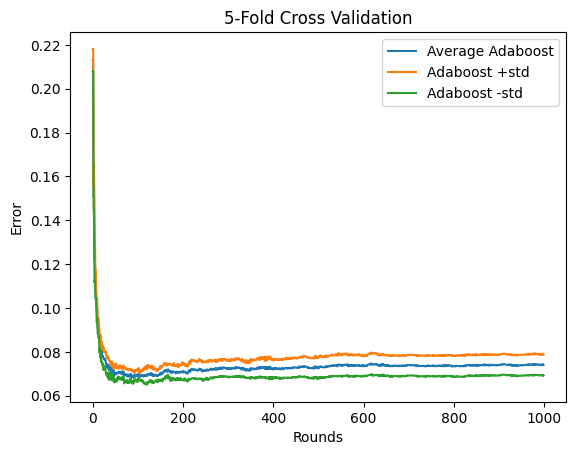

In [58]:

plt.plot(average, label = "Average Adaboost") 

avg_plus_std=average+std
plt.plot(avg_plus_std, label = "Adaboost +std") 

avg_minus_std=average-std
plt.plot(avg_minus_std, label = "Adaboost -std") 

# naming the x axis 
plt.xlabel('Rounds') 
# naming the y axis 
plt.ylabel('Error') 

# giving a title to my graph 
plt.title('5-Fold Cross Validation') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 

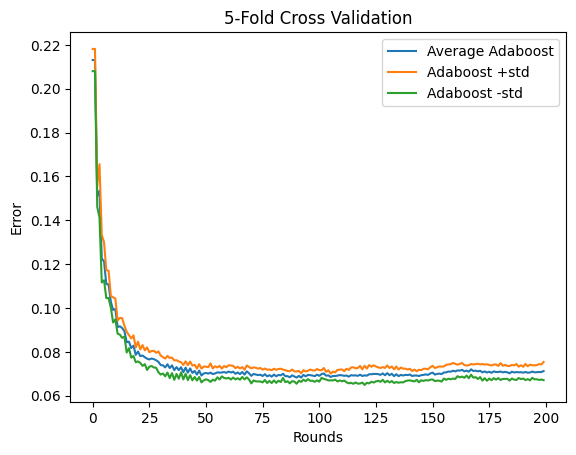

In [59]:
cut = 200
plt.plot(average[:cut], label = "Average Adaboost") 

avg_plus_std=average+std
plt.plot(avg_plus_std[:cut], label = "Adaboost +std") 

avg_minus_std=average-std
plt.plot(avg_minus_std[:cut], label = "Adaboost -std") 



  
# naming the x axis 
plt.xlabel('Rounds') 
# naming the y axis 
plt.ylabel('Error') 
# giving a title to my graph 
plt.title('5-Fold Cross Validation') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 

In [ ]:
for model in models:
    model.evaluate(test_X, test_y)
    if count==0:
        train_error = [np.array(model.train_errors)]
        test_error =  [np.array(model.test_errors)]
    else:
        train_error.append(np.array(model.train_errors))
        test_error.append(np.array(model.test_errors))
    count+=1

In [37]:
final_model = AdaBoost()
final_model.fit(train_X,train_y,n=75)

Time :0:00:08， currently at 0 rounds


In [38]:
final_model.evaluate(train_X,train_y)
train_error = final_model.test_errors

In [39]:
final_model.evaluate(test_X, test_y)
test_error = final_model.test_errors

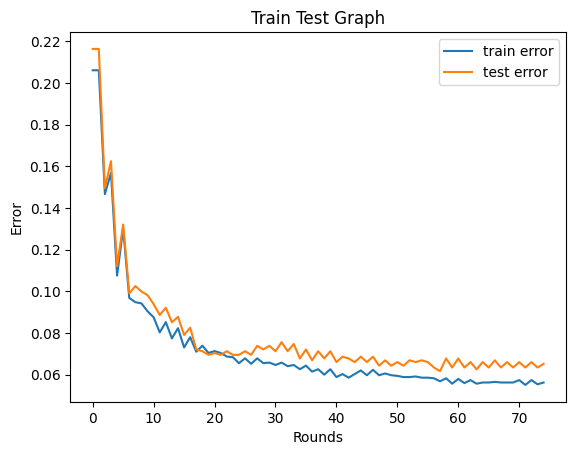

In [40]:

plt.plot(train_error, label = "train error") 

plt.plot(test_error, label = "test error") 

# naming the x axis 
plt.xlabel('Rounds')
# naming the y axis 
plt.ylabel('Error')
# giving a title to my graph 
plt.title('Train Test Graph')
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 